In [1]:
import datetime
import pytz

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplcyberpunk

from pathlib import Path
import pandas as pd
import numpy as np
from astropy.io import fits
import astropy.wcs as fitswcs
import astropy.units as u
from astropy.coordinates import EarthLocation, SkyCoord, AltAz, get_moon, Angle
from astropy.time import Time
from astropy.table import Table
import astroplan
from specutils.spectra.spectrum1d import Spectrum1D
from astropy.visualization import quantity_support
from specutils.manipulation import FluxConservingResampler

from sklearn.decomposition import PCA

_ = quantity_support()
plt.style.use("cyberpunk")
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
df = pd.read_csv("sky_spectra.csv")
moonfree = df[(df['moon_alt'] < -10) & (df['disperser'] == '270_gpm')]
moonfree

file                   ut    alt  \
1        ./2004.0413/skysub_a2034.bg_1_comb.fits  2004-04-13T08:25:25  81.18   
3        ./2004.0413/skysub_F2.20.bg_1_comb.fits  2004-04-13T05:53:13  56.71   
4           ./2004.0414/skysub_F2.bg_1_comb.fits  2004-04-14T05:11:49  65.04   
5           ./2004.0414/skysub_F2.bg_2_comb.fits  2004-04-14T07:00:59  41.07   
6           ./2004.0415/skysub_F2.bg_3_comb.fits  2004-04-15T05:48:01  55.37   
...                                          ...                  ...    ...   
4125   ./2020.1013/skysub_m31_pne_20_9_comb.fits  2020-10-13T08:16:47  66.13   
4128     ./2020.1024/skysub_jiang_c2_1_comb.fits  2020-10-24T12:04:06  65.47   
4131       ./2020.1024/skysub_Rank13_1_comb.fits  2020-10-24T08:14:37  50.94   
4132     ./2020.1025/skysub_jiang_c2_1_comb.fits  2020-10-25T11:29:55  59.13   
4135  ./2020.1025/skysub_m31_pne_20_12_comb.fits  2020-10-25T10:04:04  40.71   

          az  moon_alt  moon_az  moon_ill disperser  
1      75.47    -17.42   107.26        37   270_gpm  
3     278.43    -47.97    91.12        38   270_gpm  
4     274.96    -65.06    67.04        28   270_gpm  
5     284.86    -43.32    87.36        27   270_gpm  
6     278.13    -64.16    53.43        19   270_gpm  
...      ...       ...      ...       ...       ...  
4125  300.54    -16.84    60.23        17   270_gpm  
4128   80.09    -59.19   282.18        60   270_gpm  
4131  204.84    -13.27   252.44        58   270_gpm  
4132   78.40    -41.03   273.43        69   270_gpm  
4135  299.23    -23.64   262.57        69   270_gpm  

[2309 rows x 8 columns]

In [4]:
new_disp_grid = np.arange(3850, 6800, 2) * u.AA
fluxcon = FluxConservingResampler()

In [4]:
#fluxes = []
#for i, r in moonfree.iterrows():
#    sp = Spectrum1D.read(r['file'])
#    trim_sp = fluxcon(sp, new_disp_grid)
#    fluxes.append(trim_sp.flux)

In [4]:
#fluxes = np.array(fluxes)
#fits.writeto("sky_fluxes.fts", fluxes, overwrite=True)

NameError: name 'fluxes' is not defined

In [5]:
fluxes = fits.open('sky_fluxes.fts')[0].data

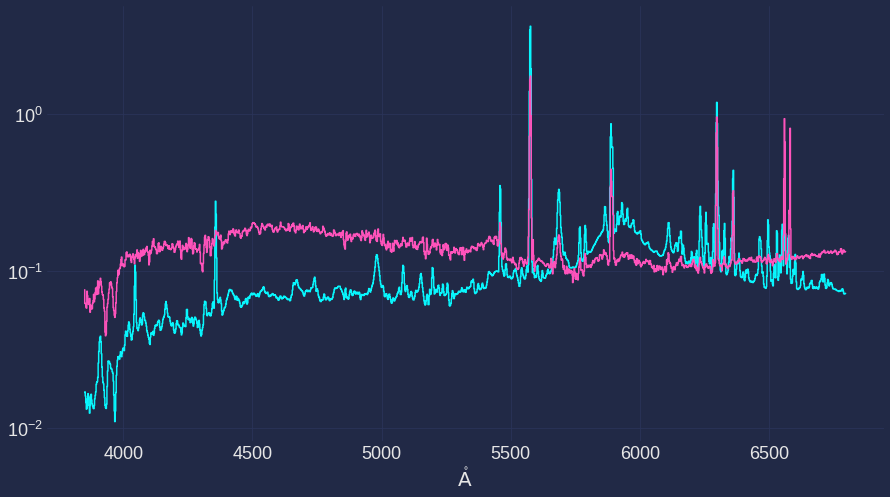

In [6]:
plt.figure(figsize=[15,8])
plt.yscale('log')
plt.step(new_disp_grid, np.mean(fluxes, axis=0))
plt.step(new_disp_grid, np.std(fluxes, axis=0))
plt.show()

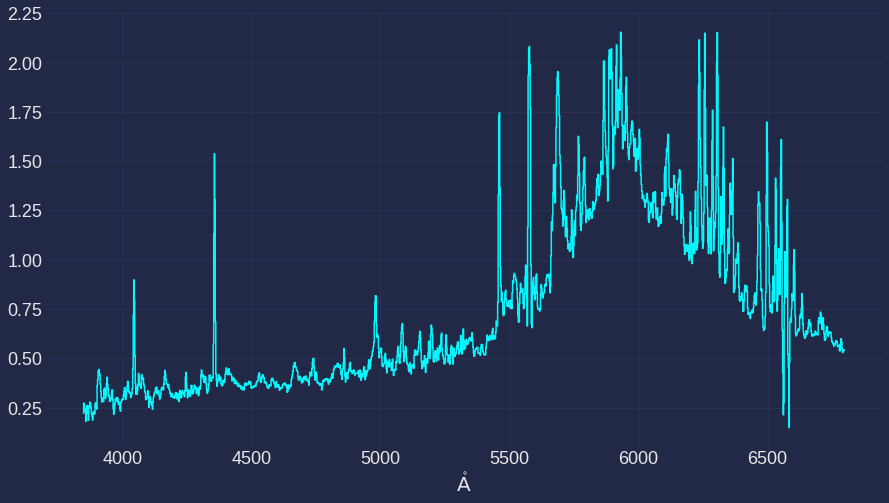

In [7]:
plt.figure(figsize=[15,8])
#plt.yscale('log')
plt.step(new_disp_grid, np.mean(fluxes, axis=0)/np.std(fluxes, axis=0))
plt.show()

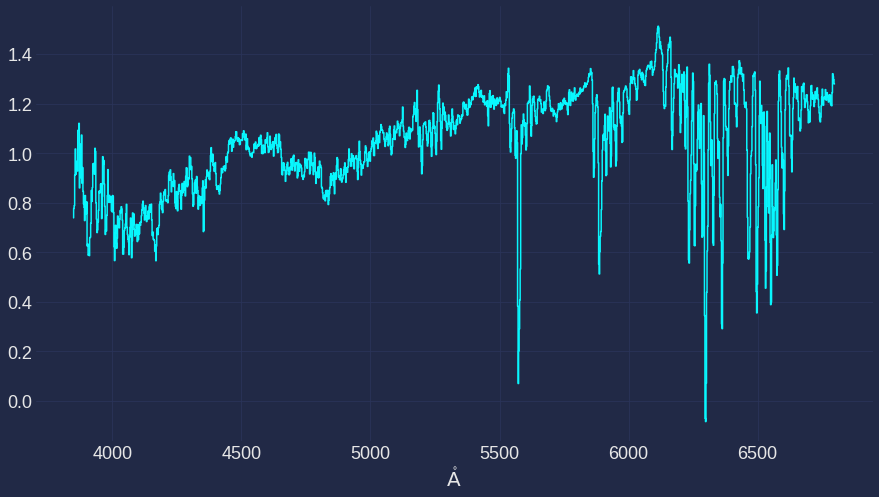

In [8]:
plt.figure(figsize=[15,8])
#plt.yscale('log')
plt.step(new_disp_grid, 2.5 * np.log10(fluxes[-1, :] / fluxes[2200, :]))
plt.show()

In [9]:
pca = PCA(n_components=16).fit(fluxes)

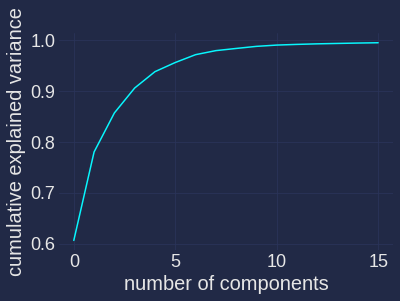

In [10]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [11]:
components = pca.transform(fluxes)
filtered = pca.inverse_transform(components)

In [12]:
components.shape

(2309, 16)

In [13]:
filtered.shape

(2309, 1475)

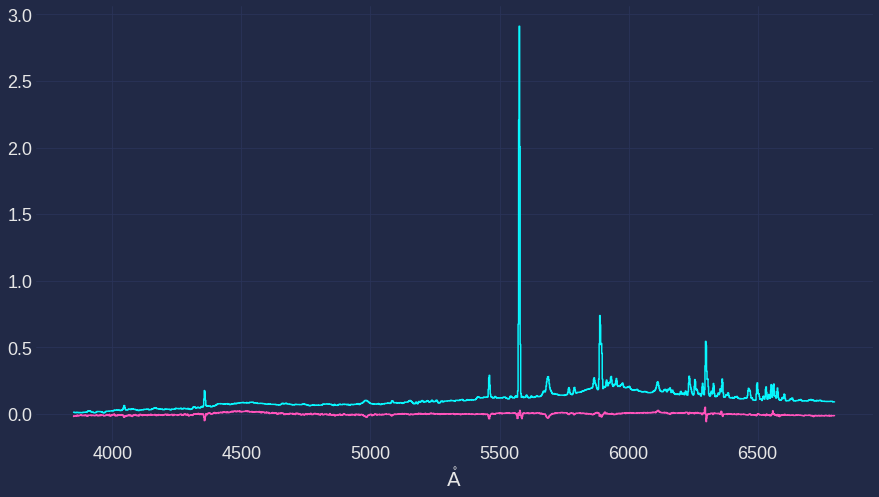

In [14]:
plt.figure(figsize=[15,8])
#plt.yscale('log')
plt.step(new_disp_grid, fluxes[-4, :])
plt.step(new_disp_grid, fluxes[-4, :] - filtered[-4, :])
plt.show()

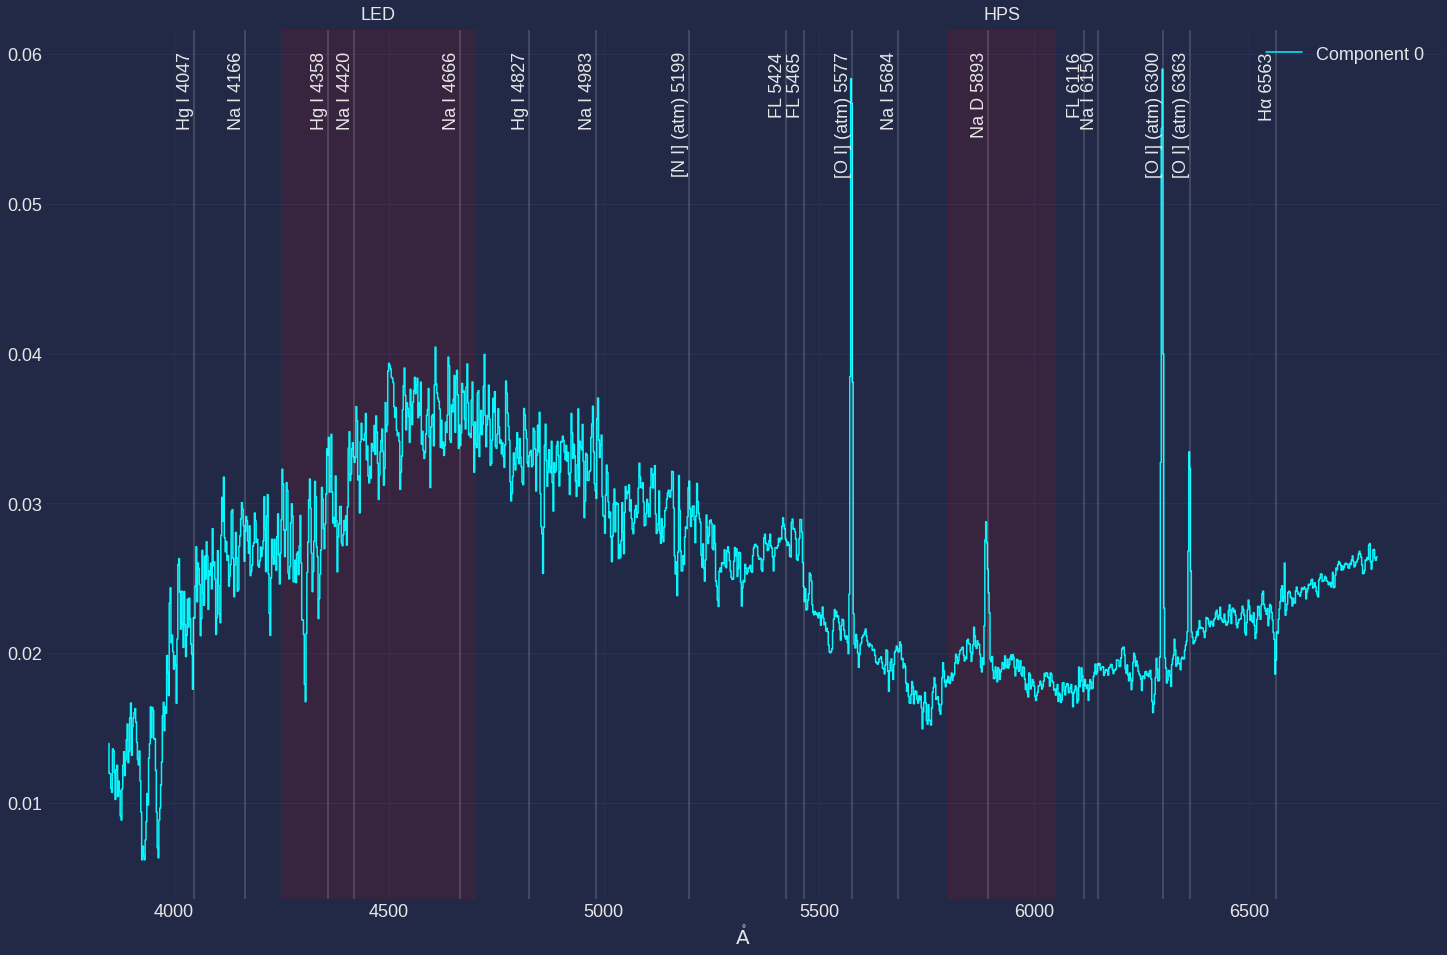

In [16]:
features = Table.read("features.csv")
plt.figure(figsize=[25,16])
#plt.yscale('log')
#for i in range(5):
    #plt.step(new_disp_grid, pca_sm.components_[i], label=f"Component {i}")
i = 0
plt.step(new_disp_grid, pca.components_[i], label=f"Component {i}")
txt_y = 1.02 * np.max(pca.components_[i])
for f in features:
    if f['low wave'] != f['high wave']:
        plt.axvspan(f['low wave'], f['high wave'], color='r', alpha=0.1)
        txt_x = 0.5*(f['low wave'] + f['high wave'])
        plt.text(txt_x, 1.05*txt_y, f['name'], horizontalalignment='center', verticalalignment='top')
    else:
        x = f['low wave']
        plt.text(x, txt_y, f"{f['name']} {x}", rotation='vertical', fontsize='medium', horizontalalignment='right', verticalalignment='top')
        plt.axvline(x, color='white', alpha=0.2)
plt.legend()
plt.show()

In [17]:
components[-1, :]

array([ 1.32715163,  1.21202569, -2.11438958, -1.10036221,  0.04728834,
       -0.02333088,  0.43063577,  0.38794274,  0.14074741, -0.50295542,
       -0.10110243,  0.05056153,  0.01697324,  0.04346641, -0.05780333,
       -0.02984214])

In [18]:
components[0, :]

array([-2.09881474e-01, -2.29452258e+00,  4.50188326e-01, -1.04057383e+00,
       -1.24920801e-01, -1.72296578e-02, -1.47683673e-01, -1.47547598e-01,
       -2.82452537e-02, -5.38782421e-02, -4.15297820e-03, -2.63036491e-04,
        1.87318341e-02, -5.91402715e-03,  6.69844974e-03, -4.42229553e-03])

In [19]:
np.arange(16).reshape(4, 4).flatten()[3]

3

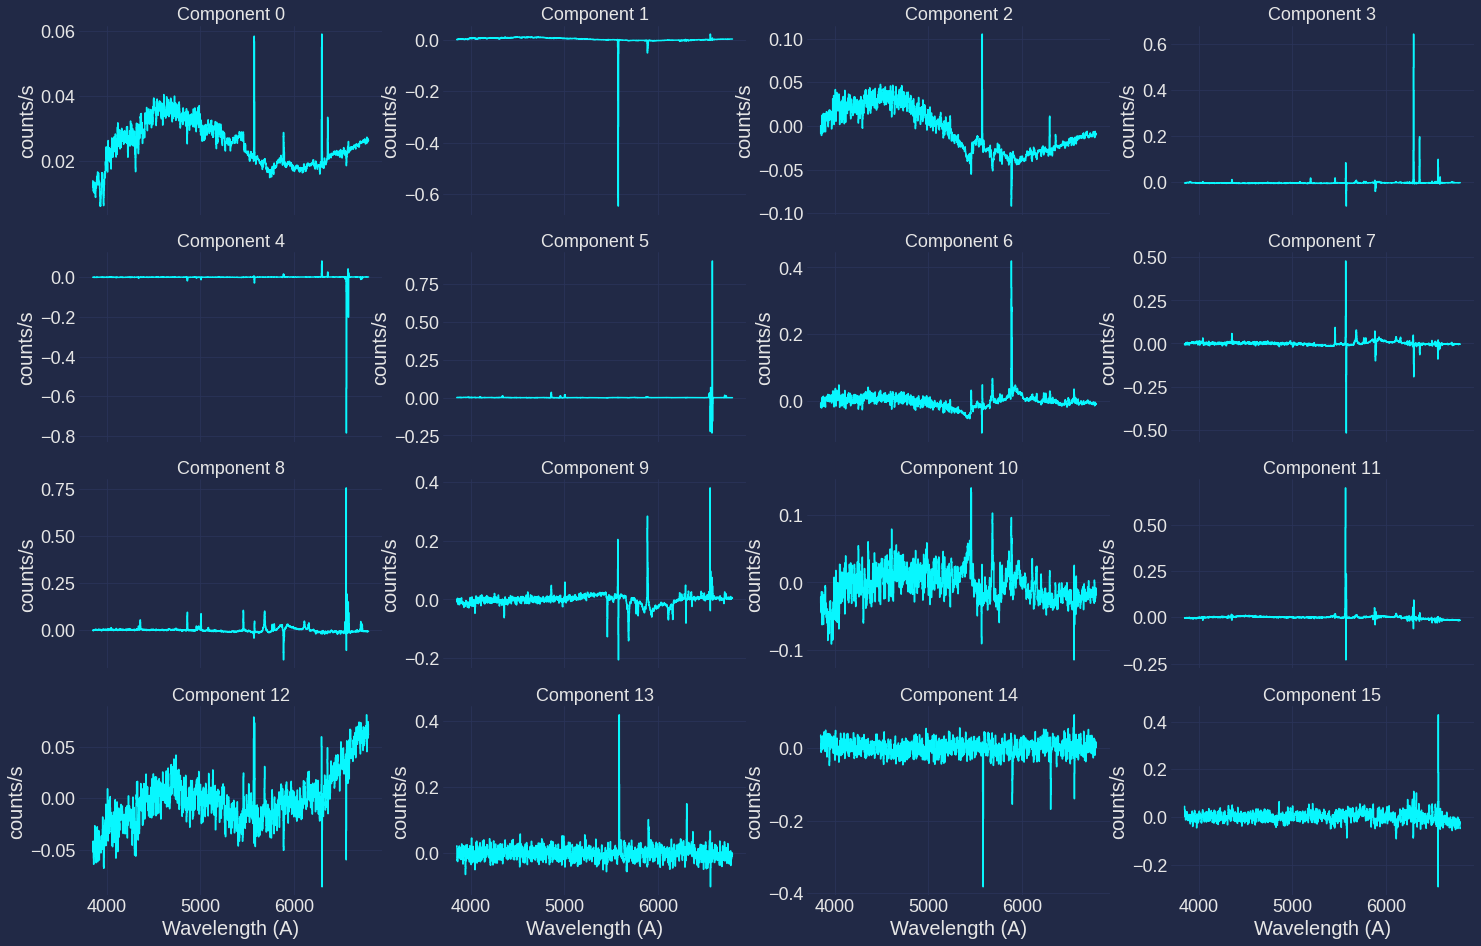

In [20]:
fig, axs = plt.subplots(4, 4, figsize=[25,16], sharex=True)
for i, ax in enumerate(axs.flat):
    ax.step(new_disp_grid, pca.components_[i])
    ax.set_title(f"Component {i}")
    ax.set_ylabel("counts/s")
    ax.set_xlabel("Wavelength (A)")
    if not ax.is_last_row():
        #ax.set_xticklabels([])
        ax.set_xlabel("")
plt.show()

In [21]:
components[:, 1].std()

2.6502438723773056

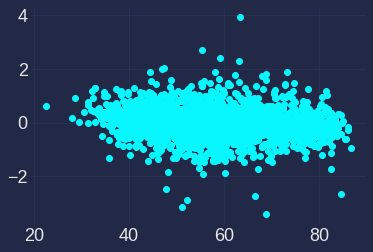

In [22]:
plt.figure()
plt.scatter(moonfree['alt'], components[:, 7])
plt.show()

In [23]:
np.argmax(components[:, 0])

1294

In [24]:
moonfree.iloc[998]

file         ./2010.1001/skysub_mah_2010C_spec_1_comb.fits
ut                                     2010-10-01T04:44:55
alt                                                  63.72
az                                                  307.76
moon_alt                                            -17.55
moon_az                                              48.31
moon_ill                                                50
disperser                                          270_gpm
Name: 1646, dtype: object

In [24]:
resid = fluxes - filtered

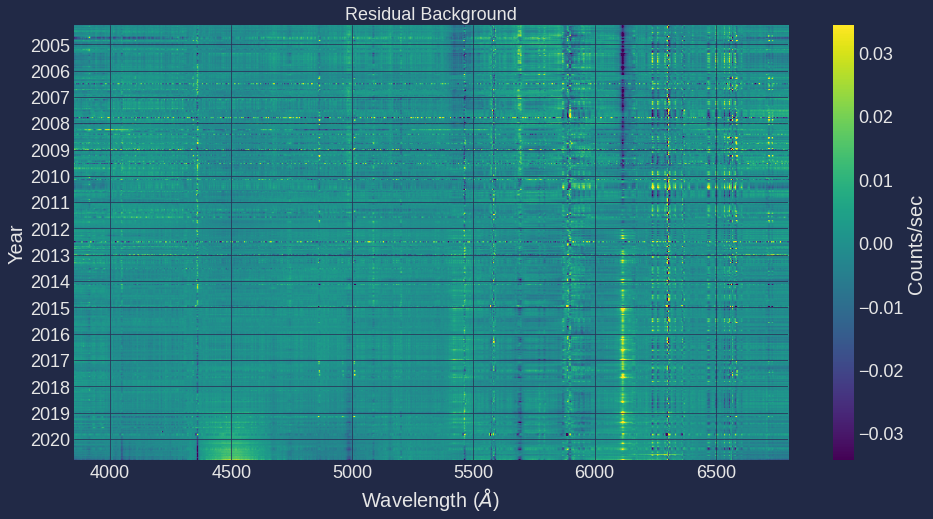

In [54]:
ut = Time(list(moonfree['ut'].values), format='isot', scale='utc')
rms = resid.std()
fig, ax = plt.subplots(figsize=[16,8])
extent = (
    new_disp_grid[0].value,
    new_disp_grid[-1].value,
    mdates.date2num(ut[-1].to_datetime()),
    mdates.date2num(ut[0].to_datetime())
)
cm = ax.imshow(resid, vmin=-3*rms, vmax=3*rms, extent=extent, aspect='auto', cmap='viridis')
ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.yaxis.set_major_locator(mdates.YearLocator())
ax.set_xlabel("Wavelength ($\AA$)")
ax.set_ylabel("Year")
ax.set_title("Residual Background")
cb = fig.colorbar(cm, ax=ax)
cb.set_label("Counts/sec")
plt.savefig("resid.png")
plt.show()

In [44]:
new_disp_grid[1132].value

6114.0

In [46]:
ut[-1]

<Time object: scale='utc' format='isot' value=2020-10-25T10:04:04.000>

In [27]:
new_disp_grid[919]

<Quantity 5688. Angstrom>

In [70]:
new_disp_grid[567]

<Quantity 4984. Angstrom>

In [29]:
fits.writeto("resid.fits", resid)

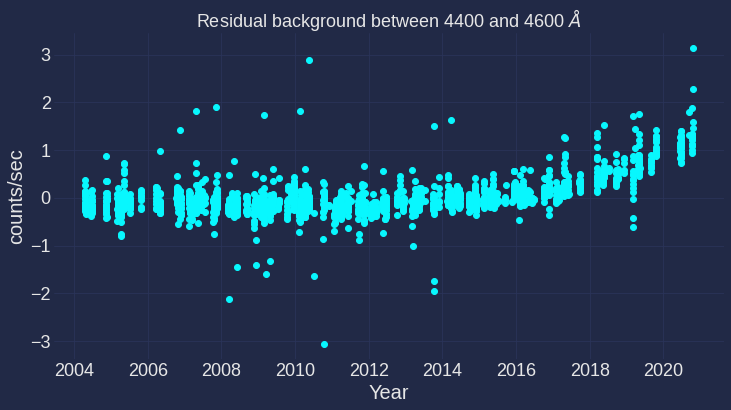

In [53]:
led = np.sum(resid[:, 275:375], axis=1)
plt.figure(figsize=[12,6])
plt.scatter(ut.to_datetime(), led)
plt.xlabel("Year")
plt.ylabel("counts/sec")
plt.title("Residual background between 4400 and 4600 $\AA$")
plt.savefig("led.png")
plt.show()

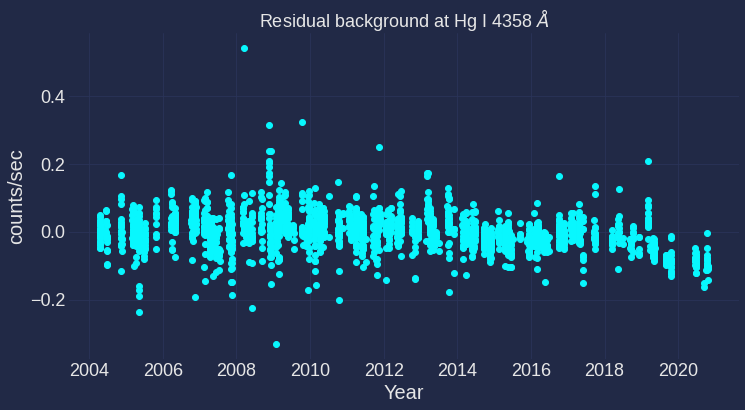

In [56]:
hg_4358 = np.sum(resid[:, 254:258], axis=1)
plt.figure(figsize=[12,6])
plt.scatter(ut.to_datetime(), hg_4358)
plt.xlabel("Year")
plt.ylabel("counts/sec")
plt.title("Residual background at Hg I 4358 $\AA$")
plt.savefig("hg_4358.png")
plt.show()

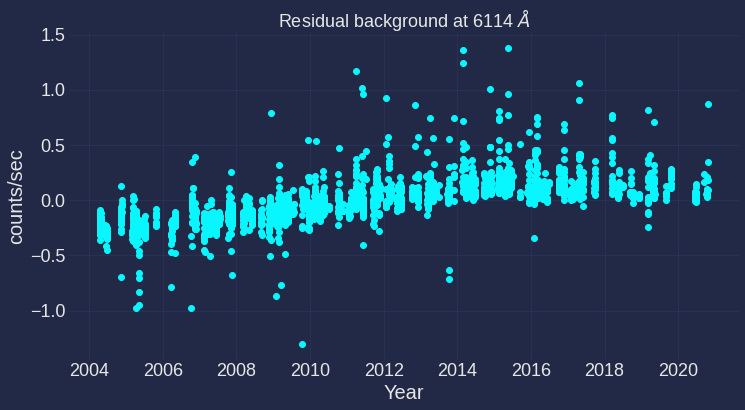

In [57]:
fl_6114 = np.sum(resid[:, 1126:1136], axis=1)
plt.figure(figsize=[12,6])
plt.scatter(ut.to_datetime(), fl_6114)
plt.xlabel("Year")
plt.ylabel("counts/sec")
plt.title("Residual background at 6114 $\AA$")
plt.savefig("fl_6614.png")
plt.show()

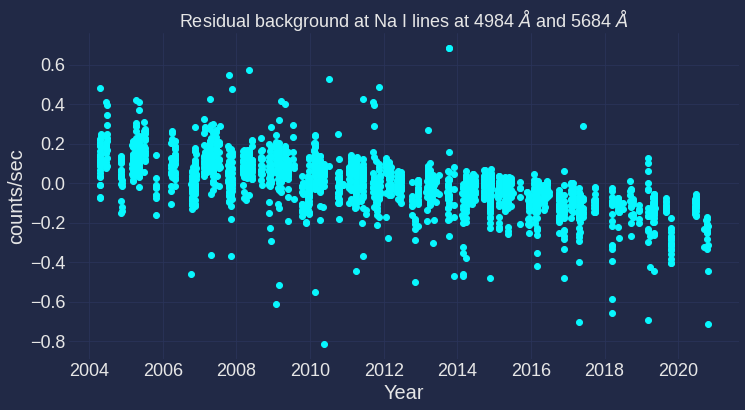

In [58]:
nai_4984 = np.sum(resid[:, 562:571], axis=1)
nai_5684 = np.sum(resid[:, 915:922], axis=1)
nai = nai_4984 + nai_5684
plt.figure(figsize=[12,6])
plt.scatter(ut.to_datetime(), nai)
plt.xlabel("Year")
plt.ylabel("counts/sec")
plt.title("Residual background at Na I lines at 4984 $\AA$ and 5684 $\AA$")
plt.savefig("nai.png")
plt.show()